### Import Library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

### Import Data

In [4]:
df = pd.read_csv("..\Loan_status_2007-2020Q3.csv", nrows=1000000)

C:\Users\User\AppData\Local\Temp\ipykernel_16404\2261176854.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("..\Loan_status_2007-2020Q3.csv", nrows=1000000)


In [5]:
needed_columns = [
    "loan_amnt",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",
    "emp_length",
    "home_ownership",
    "issue_d",
    "verification_status",
    "purpose",
    "dti",
    "delinq_2yrs",
    "loan_status",
    "zip_code",
    "avg_cur_bal",
    "revol_bal",
]
df = df[needed_columns]
print(df.head())

   loan_amnt        term int_rate  installment grade sub_grade emp_length  \
0     5000.0   36 months   10.65%       162.87     B        B2  10+ years   
1     2500.0   60 months   15.27%        59.83     C        C4   < 1 year   
2     2400.0   36 months   15.96%        84.33     C        C5  10+ years   
3    10000.0   36 months   13.49%       339.31     C        C1  10+ years   
4     3000.0   60 months   12.69%        67.79     B        B5     1 year   

  home_ownership   issue_d verification_status         purpose    dti  \
0           RENT  Dec-2011            Verified     credit_card  27.65   
1           RENT  Dec-2011     Source Verified             car   1.00   
2           RENT  Dec-2011        Not Verified  small_business   8.72   
3           RENT  Dec-2011     Source Verified           other  20.00   
4           RENT  Dec-2011     Source Verified           other  17.94   

   delinq_2yrs  loan_status zip_code  avg_cur_bal  revol_bal  
0          0.0   Fully Paid    860x

In [6]:
df = df.dropna()
print("\nNull value count")
for col in needed_columns:
    print("{} = {}".format(col, df[col].isnull().sum()))


Null value count
loan_amnt = 0
term = 0
int_rate = 0
installment = 0
grade = 0
sub_grade = 0
emp_length = 0
home_ownership = 0
issue_d = 0
verification_status = 0
purpose = 0
dti = 0
delinq_2yrs = 0
loan_status = 0
zip_code = 0
avg_cur_bal = 0
revol_bal = 0


In [7]:
df["int_rate"] = df["int_rate"].astype(str)
df["term"] = df["term"].astype(str)

df["int_rate"] = df["int_rate"].str.replace("%", "").str.strip()
df["int_rate"] = pd.to_numeric(df["int_rate"], errors='coerce')

df["term"] = df["term"].str.replace("months", "").str.strip()
df["term"] = pd.to_numeric(df["term"], errors='coerce')

In [8]:
print(df.head())

       loan_amnt  term  int_rate  installment grade sub_grade emp_length  \
42536    12000.0    36     10.99       392.81     B        B2    4 years   
42537     4800.0    36     10.99       157.13     B        B2    2 years   
42538    27050.0    36     10.99       885.46     B        B2  10+ years   
42539    12000.0    36      7.62       373.94     A        A3    3 years   
42540    14000.0    36     12.85       470.71     B        B4    4 years   

      home_ownership   issue_d verification_status             purpose    dti  \
42536           RENT  Dec-2013        Not Verified  debt_consolidation   4.62   
42537       MORTGAGE  Dec-2013     Source Verified    home_improvement   2.49   
42538            OWN  Dec-2013            Verified  debt_consolidation  22.87   
42539       MORTGAGE  Dec-2013        Not Verified  debt_consolidation  12.61   
42540           RENT  Dec-2013        Not Verified  debt_consolidation  10.02   

       delinq_2yrs loan_status zip_code  avg_cur_bal  re

<Axes: title={'center': 'Loan Status Values for Lending Club'}>

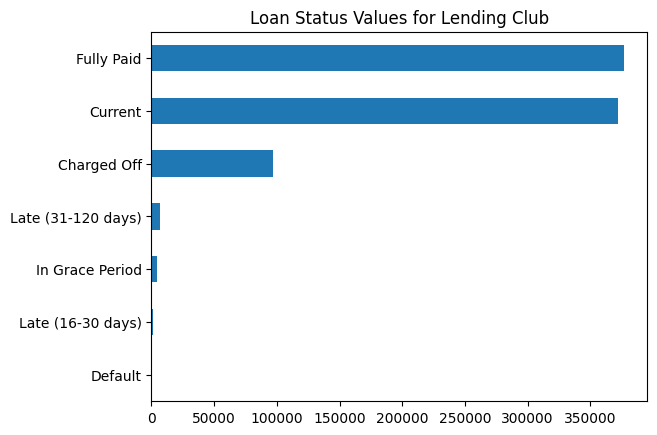

In [9]:
df["loan_status"].dropna().value_counts().sort_values().plot(
    kind="barh", title="Loan Status Values for Lending Club"
)

<Axes: title={'center': 'Loan Grades for Lending Club'}>

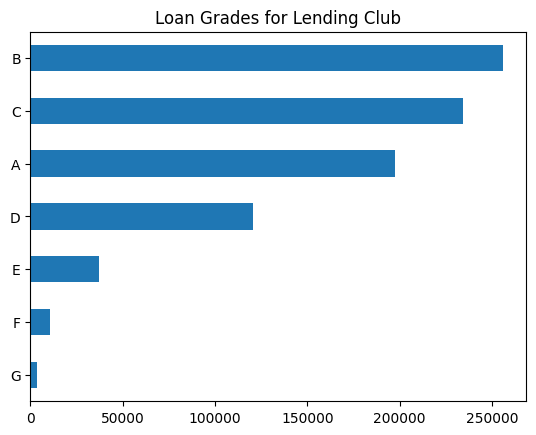

In [10]:
df["grade"].value_counts().sort_values().plot(
    kind="barh", title="Loan Grades for Lending Club"
)

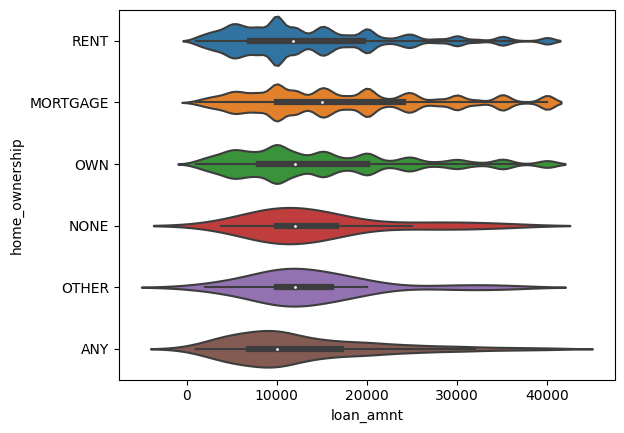

In [11]:
sns.violinplot(x="loan_amnt", y="home_ownership", data=df)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

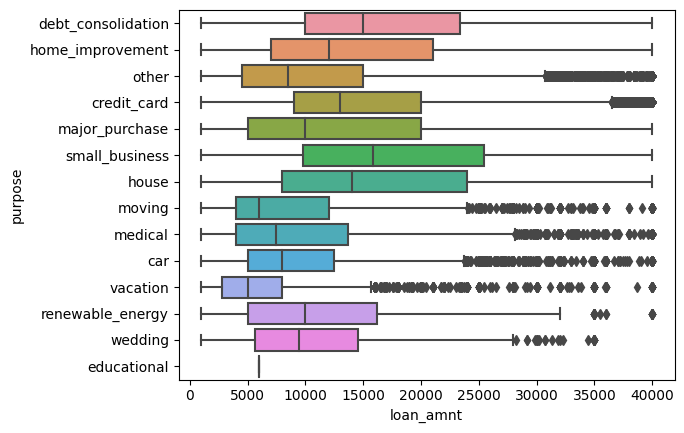

In [12]:
sns.boxplot(x="loan_amnt", y="purpose", data=df)
plt.show

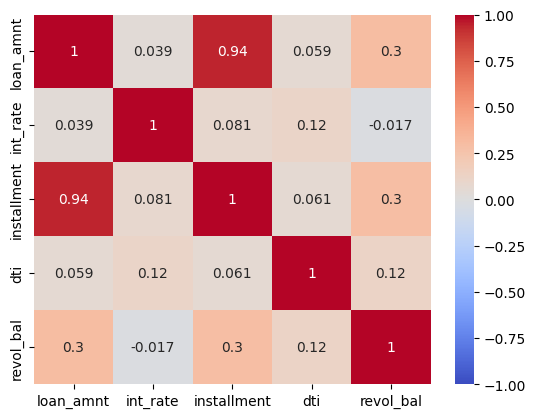

In [13]:
numeric_df = df[["loan_amnt", "int_rate", "installment", "dti", "revol_bal"]]
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [14]:
le = LabelEncoder()
df["emp_length"] = le.fit_transform(df["emp_length"])
df["grade"] = le.fit_transform(df["grade"])
df["sub_grade"] = le.fit_transform(df["sub_grade"])
df["home_ownership"] = le.fit_transform(df["home_ownership"])
df["issue_d"] = le.fit_transform(df["issue_d"])
df["verification_status"] = le.fit_transform(df["verification_status"])
df["purpose"] = le.fit_transform(df["purpose"])
df["loan_status"] = le.fit_transform(df["loan_status"])
df["zip_code"] = le.fit_transform(df["zip_code"])

X = df.drop("loan_status", axis=1)  # Features
y = df["loan_status"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Precision:", precision_dt)
print("Decision Tree Recall:", recall_dt)
print("Decision Tree F1-Score:", f1_dt)

Decision Tree Accuracy: 0.5004442788907384
Decision Tree Precision: 0.5052222931585774
Decision Tree Recall: 0.5004442788907384
Decision Tree F1-Score: 0.5027698659953561


In [16]:
print(
    "Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt)
)

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.18      0.17     29161
           1       0.56      0.55      0.56    111692
           2       0.00      0.00      0.00        39
           3       0.55      0.55      0.55    113078
           4       0.01      0.01      0.01      1312
           5       0.00      0.00      0.00       305
           6       0.01      0.01      0.01      2134

    accuracy                           0.50    257721
   macro avg       0.19      0.19      0.19    257721
weighted avg       0.51      0.50      0.50    257721



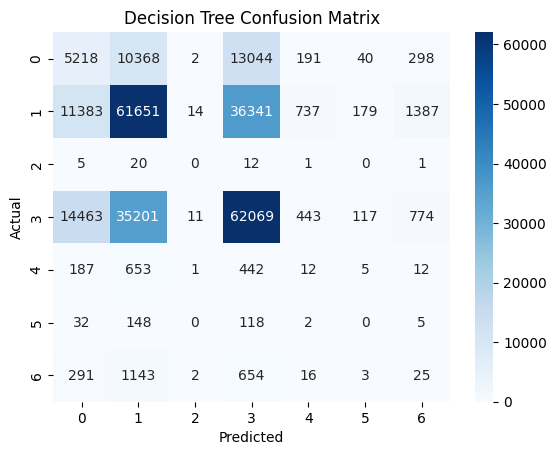

In [17]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [19]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print(
    "Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf)
)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.04      0.07     29161
           1       0.59      0.76      0.66    111692
           2       0.00      0.00      0.00        39
           3       0.63      0.61      0.62    113078
           4       0.00      0.00      0.00      1312
           5       0.00      0.00      0.00       305
           6       0.00      0.00      0.00      2134

    accuracy                           0.60    257721
   macro avg       0.22      0.20      0.19    257721
weighted avg       0.57      0.60      0.57    257721



C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


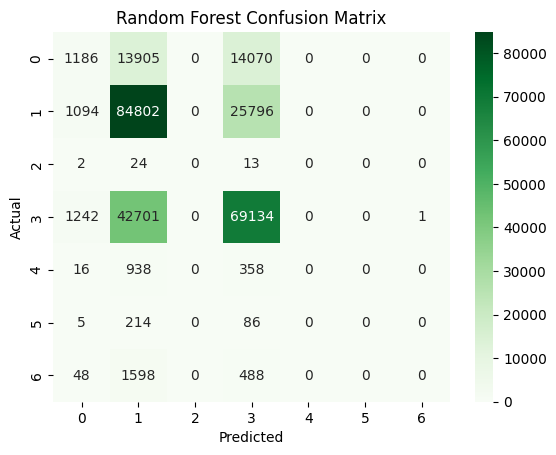

In [21]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()